In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/jls/work/code/nbody/')
import nbody_tools
from scipy.stats import cauchy
import sys
sys.path.append('../dSphs/code/')
from triaxial_properties import *
from orbit import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
crater2_slos, crater2_slos_err = 2.7, 0.3
crater2_rh, crater2_rh_err = 1.066, 0.084
crater2_eps_err = 0.05
walker_slope,walker_slope_up_err,walker_slope_down_err = 1.271, 0.15, 0.19
vmax_sawala,sig_vmax_sawala = 17.6, 3.2
c=20.
Delta=101.1
log10c = np.log10(c)
log10c_spread = 0.13 ## Maccio et al. (2007)

ca_mean,ca_width=0.45,0.15
def shapeprior(ca):
    return -(ca-0.45)**2/(2.*0.15**2) ## All result from Sanders & Evans (2017)

from scipy.optimize import brentq

def slos_r(r,vmax,c=c,Delta=Delta):
    rsdm = nbody_tools.rs_Vmax(vmax,c,Delta=Delta)
    return vmax*np.sqrt(1.85)*np.sqrt(rsdm/r*(np.log(1.+r/rsdm)-r/(rsdm+r)))

def slos_Rh(Rh,vmax,c=c,Delta=Delta):
    return slos_r(4.*Rh/3.,vmax,c=c,Delta=Delta)

def vmax_slos_Rh(slos,Rh,c=c,Delta=Delta):
    def fnn(vmax):
        return slos**2-slos_Rh(Rh,vmax,c=c,Delta=Delta)**2
    return brentq(fnn,0.005,5000.)

eq = crater2_eq()
solar_reflex = crater2_solarreflex()

veldisp=140.
mudisp = veldisp/4.74/distance

pmra_list,pmdec_list = [], []

def mass_loss_formula(mu_abs, scl=0.11):
    return 1.-np.exp(-mu_abs/scl)

def find_mass_loss(mu1,mu2,time):
    Eq = np.array([eq[0],eq[1],distance,vlos,
                    mu1,mu2])
    R,T = integrate_orbits_backwards(Eq, total_time=time)
    nperi = count_pericentres(R)
    pmmag = np.sqrt((mu1-solar_reflex[0])**2+(mu2-solar_reflex[1])**2)
    return np.power(mass_loss_formula(pmmag),nperi)

def logl(p, spherical=False, tidal_stripping=True, using_universal=True):
    
    phi,theta,ba,ca,slostrue,rhtrue,log10conc,mu1,mu2,time=\
        p[0],p[1],p[2],p[3],np.exp(p[4]),np.exp(p[5]),p[6],p[7],p[8],p[9]
    if time>13.7 or time<0.:
        return -np.inf
    Eq = np.array([eq[0],eq[1],distance,vlos,
                    mu1,mu2])
    R,T = integrate_orbits_backwards(Eq, total_time=time)
    
    if len(R)==0:
        return -np.inf
    nperi = count_pericentres(R)
    if nperi==0:
        return -np.inf
    
    pmmag = np.sqrt((mu1-solar_reflex[0])**2+(mu2-solar_reflex[1])**2)
    mf = np.power(mass_loss_formula(pmmag),nperi)
    mfprior=1e-2
    if not tidal_stripping:
        mfprior=0.95
    caprior=1e-2
    if spherical:
        caprior=0.95
    
    if(theta<0. or theta>np.pi/2. or phi<0. or phi>np.pi/2. or ba<ca or ba>1. or ca<caprior or ca>1. 
       or mf>1. or mf<mfprior):
        return -np.inf
    
    epsi = ellipticity(ba,ca,theta,phi)
    
    ss = np.sqrt(sigma_tot_to_sigma_los(ba,ca,theta,phi)) ## Function returns square
    sigma_total = slostrue*ss
    rh_average_factor = radial_factor(ba,ca,theta,phi)*np.power(ba*ca,1./3.)
    r_total = rhtrue*rh_average_factor
    
    mass = sigma_total**2*r_total
    
    rh_obs = rhtrue*penarrubia_tracks(mf)[1]
    sigma_obs = slostrue*penarrubia_tracks(mf)[0]
    
    if using_universal:
        vmax = vmax_slos_Rh(sigma_total,r_total,c=np.power(10.,log10conc))
        relation = -.5*(vmax-vmax_sawala)**2/sig_vmax_sawala**2 # Don't need divide by sig as not changing
    else:
        A = np.log10(sigma_total)-0.5*np.log10(r_total)
        sig=walker_slope_down_err
        if(A>walker_slope):
            sig=walker_slope_up_err
        relation = -.5*(A-walker_slope)**2/sig**2-np.log(sig)
    
    return np.log(np.sin(theta))+relation\
            -.5*(crater2_rh-rh_obs)**2/crater2_rh_err**2-.5*(sigma_obs-crater2_slos)**2/crater2_slos_err**2\
            -.5*(epsi)**2/crater2_eps_err**2 \
            + shapeprior(ca)  \
            -.5*(log10conc-log10c)**2/log10c_spread**2
            
def run(name,nsteps=2000,spherical=False, tidal_stripping=True,using_universal=True):
    import emcee
    nwalkers=200
    caprior=1e-3
    if spherical:
        caprior=0.95
        
    sampler = emcee.EnsembleSampler(nwalkers,10,logl,
                                    kwargs={'spherical':spherical,'tidal_stripping':tidal_stripping})
    low = [0.,
           0.,
           caprior/2.+.5,
           caprior,
           np.log(crater2_slos-crater2_slos_err),
           np.log(crater2_rh-crater2_rh_err),
           log10c-log10c_spread,solar_reflex[0]+0.02,solar_reflex[1]+0.02,0.1]
    high = [np.pi/2.,
            np.pi/2.,
            0.99,
            caprior/2.+.5,
            np.log(crater2_slos+crater2_slos_err),
            np.log(crater2_rh+crater2_rh_err),
            log10c+log10c_spread,
           solar_reflex[0]+0.2,solar_reflex[1]+0.2,13.7]

    p0 = np.array([np.random.uniform(low=l,high=h,size=nwalkers) for l,h in zip(low,high)]).T
    s = sampler.run_mcmc(p0,nsteps)
    sampler.reset()
    s = sampler.run_mcmc(s[0],nsteps/4)
    ss = sampler.flatchain.copy()
    phi,theta,ba,ca=ss.T[0],ss.T[1],ss.T[2],ss.T[3]    
    ss.T[4]=np.exp(ss.T[4]);ss.T[5]=np.exp(ss.T[5])
    eps_dist = ellipticity(ba,ca,theta,phi)
    sratio = np.sqrt(np.array([sigma_tot_to_sigma_los(b,CA,t,p) for b,CA,t,p in zip(ba,ca,theta,phi)])) ## Function returns square
    rratio = radial_factor(ba,ca,theta,phi)*np.power(ba*ca,1./3.)
    mf = np.array([find_mass_loss(m1,m2,tt) for m1,m2,tt in zip(ss.T[7],ss.T[8],ss.T[9])])
    sig_obs = ss.T[4]*penarrubia_tracks(mf)[0]
    rh_obs = ss.T[5]*penarrubia_tracks(mf)[1]
    sig_total = ss.T[4]*sratio
    r_total = ss.T[5]*rratio
    sig_ratio = sig_obs/sig_total
    rh_ratio = rh_obs/r_total
#     ss.T[6]=np.log10(np.exp(ss.T[6]))
    gg = np.vstack((ss.T,sig_obs,rh_obs,eps_dist)).T

    bins = 30 
    from corner import corner
    f = corner(gg,
               labels=[r'$\phi/\,\mathrm{rad}$',r'$\theta/\,\mathrm{rad}$',
                       '$b/a$','$c/a$','$\sigma_\mathrm{los,init}/\,\mathrm{km\,s}^{-1}$',
                       '$r_{h,\mathrm{init}}/\mathrm{kpc}$',
                       '$\log_{10}c$','mu_1','mu_2','t',
                       '$\sigma_\mathrm{los}/\,\mathrm{km\,s}^{-1}$',
                       '$r_h/\mathrm{kpc}$','$\epsilon$'],bins=bins);
    nlen = len(gg.T)+1
    ax = f.get_axes()[nlen*3]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx-ca_mean)**2/ca_width**2)/np.sqrt(2.*np.pi*ca_width**2)*len(ss)*bwidth)
    
    ax = f.get_axes()[nlen*6]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,1./np.pi/(1.+(xx/0.38)**2)*len(ss)*bwidth)
    
    ax = f.get_axes()[nlen*7]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx-log10c)**2/log10c_spread**2)/np.sqrt(2.*np.pi*log10c_spread**2)*len(ss)*bwidth)
    
    ax = f.get_axes()[nlen*8]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx-crater2_slos)**2/crater2_slos_err**2)/np.sqrt(2.*np.pi*crater2_slos_err**2)*len(ss)*bwidth)
    ax = f.get_axes()[nlen*9]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx-crater2_rh)**2/crater2_rh_err**2)/np.sqrt(2.*np.pi*crater2_rh_err**2)*len(ss)*bwidth)
    ax = f.get_axes()[nlen*10]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx)**2/crater2_eps_err**2)/np.sqrt(2.*np.pi*crater2_eps_err**2)*len(ss)*bwidth)
    plt.sca(ax)
    plt.axvline(2.*crater2_eps_err,color=sns.color_palette()[0],ls='dashed')
    
    np.savetxt(name+'_mass_samples.dat',ss.T[6])
    
    plt.savefig(name+'_corner.png',bbox_inches='tight',dpi=300)
    
    plt.figure()
    bins = 30 
    from corner import corner
    gg2 = np.vstack((gg.T[1],gg.T[2],gg.T[3],gg.T[6])).T
    f = corner(gg2,
               labels=[r'$\theta/\,\mathrm{rad}$',
                       '$b/a$','$c/a$',
                       r'$\log_{10}(M_\mathrm{h}/M_\mathrm{h0})$']
               ,bins=bins);
    ax = f.get_axes()[10]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,np.exp(-.5*(xx-ca_mean)**2/ca_width**2)/np.sqrt(2.*np.pi*ca_width**2)*len(ss)*bwidth)
    
    ax = f.get_axes()[15]
    xr=ax.get_xlim()
    xx=np.linspace(xr[0],xr[1],1000)
    bwidth=(xr[1]-xr[0])/float(bins)
    ax.plot(xx,1./np.pi/(1.+(xx/0.38)**2)*len(ss)*bwidth)

    ax_inset = plt.axes([.6, .62, .3, .25])
    plt.sca(ax_inset)
    under_line = sig_total/np.power(10.,walker_slope+0.5*np.log10(r_total))
    if using_universal:
        under_line = sig_total/slos_Rh(r_total,vmax_sawala,c=np.power(10.,ss.T[7]),Delta=Delta)
    srat,rrat,tidal_s,shape_s = sig_ratio, rh_ratio, penarrubia_tracks(np.power(10.,ss.T[6]))[0], 1./sratio
    plt.hist(under_line,histtype='step',lw=2,bins=40,range=[0.,1.],label='Scatter');
    plt.hist(shape_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Shape');
    plt.hist(tidal_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Tidal');
    plt.hist(tidal_s*under_line*shape_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Total');

    plt.xlim(0.,1.)
    plt.legend(loc='lower center',ncol=2, bbox_to_anchor=(0.5,1.03))
    plt.xlabel(r'$\sigma_\mathrm{los}/\sigma_\mathrm{los,pred.}$')
    plt.semilogy()
    
    plt.savefig(name+'_corner_reduced.png',bbox_inches='tight',dpi=300)

    def plt_contour(x,y,cm=plt.cm.Blues):
        H,X,Y = np.histogram2d(np.log10(x),np.log10(y),bins=20)
        X,Y=np.meshgrid(.5*(X[1:]+X[:-1]),.5*(Y[1:]+Y[:-1]))
        plt.contour(np.power(10.,X),np.power(10.,Y),np.log10(H.T),cmap=cm)

    plt.figure()
    plt.semilogy();plt.semilogx();
    plt_contour(ss.T[5],ss.T[4])
    
    plt_contour(r_total,sig_total,cm=plt.cm.Greens)
    plt_contour(rh_obs,sig_obs,cm=plt.cm.Reds)
    
    xx = np.logspace(-2.,2.)
    plt.plot(xx,10**walker_slope*xx**0.5,color='k')
    plt.fill_between(xx,10**(walker_slope-walker_slope_down_err)*xx**0.5,
                     10**(walker_slope+walker_slope_up_err)*xx**0.5,color='gray',alpha=0.4)
    plt.plot(xx,slos_Rh(xx,vmax_sawala))
    plt.fill_between(xx,slos_Rh(xx,vmax_sawala-sig_vmax_sawala),
                     slos_Rh(xx,vmax_sawala+sig_vmax_sawala),color=sns.color_palette()[0],alpha=0.4)

    plt.ylabel('$\sigma_\mathrm{los}/\,\mathrm{km\,s}^{-1}$')
    plt.xlabel('$r_h/\mathrm{kpc}$')
    plt.annotate('Spherically averaged',[0.03,20.],fontsize=16)
    plt.annotate('Pre-tidal\nstripping',[2.,2.3],fontsize=16)
    plt.annotate('Observation',[0.2,1.4],fontsize=16)
    xx = np.logspace(-2.,0.)
    plt.plot(penarrubia_tracks(xx)[1]*5.,penarrubia_tracks(xx)[0]*40.,color='k')
    plt.xlim(0.01,10.)
    plt.ylim(1.,100.)
    plt.savefig(name+'_slos_rh.png',bbox_inches='tight',dpi=300)
    
    under_line = sig_total/np.power(10.,walker_slope+0.5*np.log10(r_total))
    if using_universal:
        under_line = sig_total/slos_Rh(r_total,vmax_sawala,c=np.power(10.,ss.T[7]),Delta=Delta)
    srat,rrat,tidal_s,shape_s = sig_ratio, rh_ratio, penarrubia_tracks(np.power(10.,ss.T[6]))[0], 1./sratio
    plt.figure()
    plt.hist(under_line,histtype='step',lw=2,bins=40,range=[0.,1.],label='Scatter');
    plt.hist(shape_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Shape');
    plt.hist(tidal_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Tidal');
    plt.hist(tidal_s*under_line*shape_s,histtype='step',lw=2,bins=40,range=[0.,1.],label='Total');
    print (tidal_s*under_line*shape_s)[0]
    print slos_Rh(r_total,vmax_sawala,c=c,Delta=Delta)[0]
    
    plt.xlim(0.,1.)
    plt.legend(loc='lower right',ncol=1)
    plt.xlabel(r'$\sigma_\mathrm{los}/\sigma_\mathrm{los,sph,unperturb.}$')
    plt.semilogy()
    plt.savefig(name+'_sig_ratio.png',bbox_inches='tight',dpi=300)

3.2227266059739277
10.307489113512444


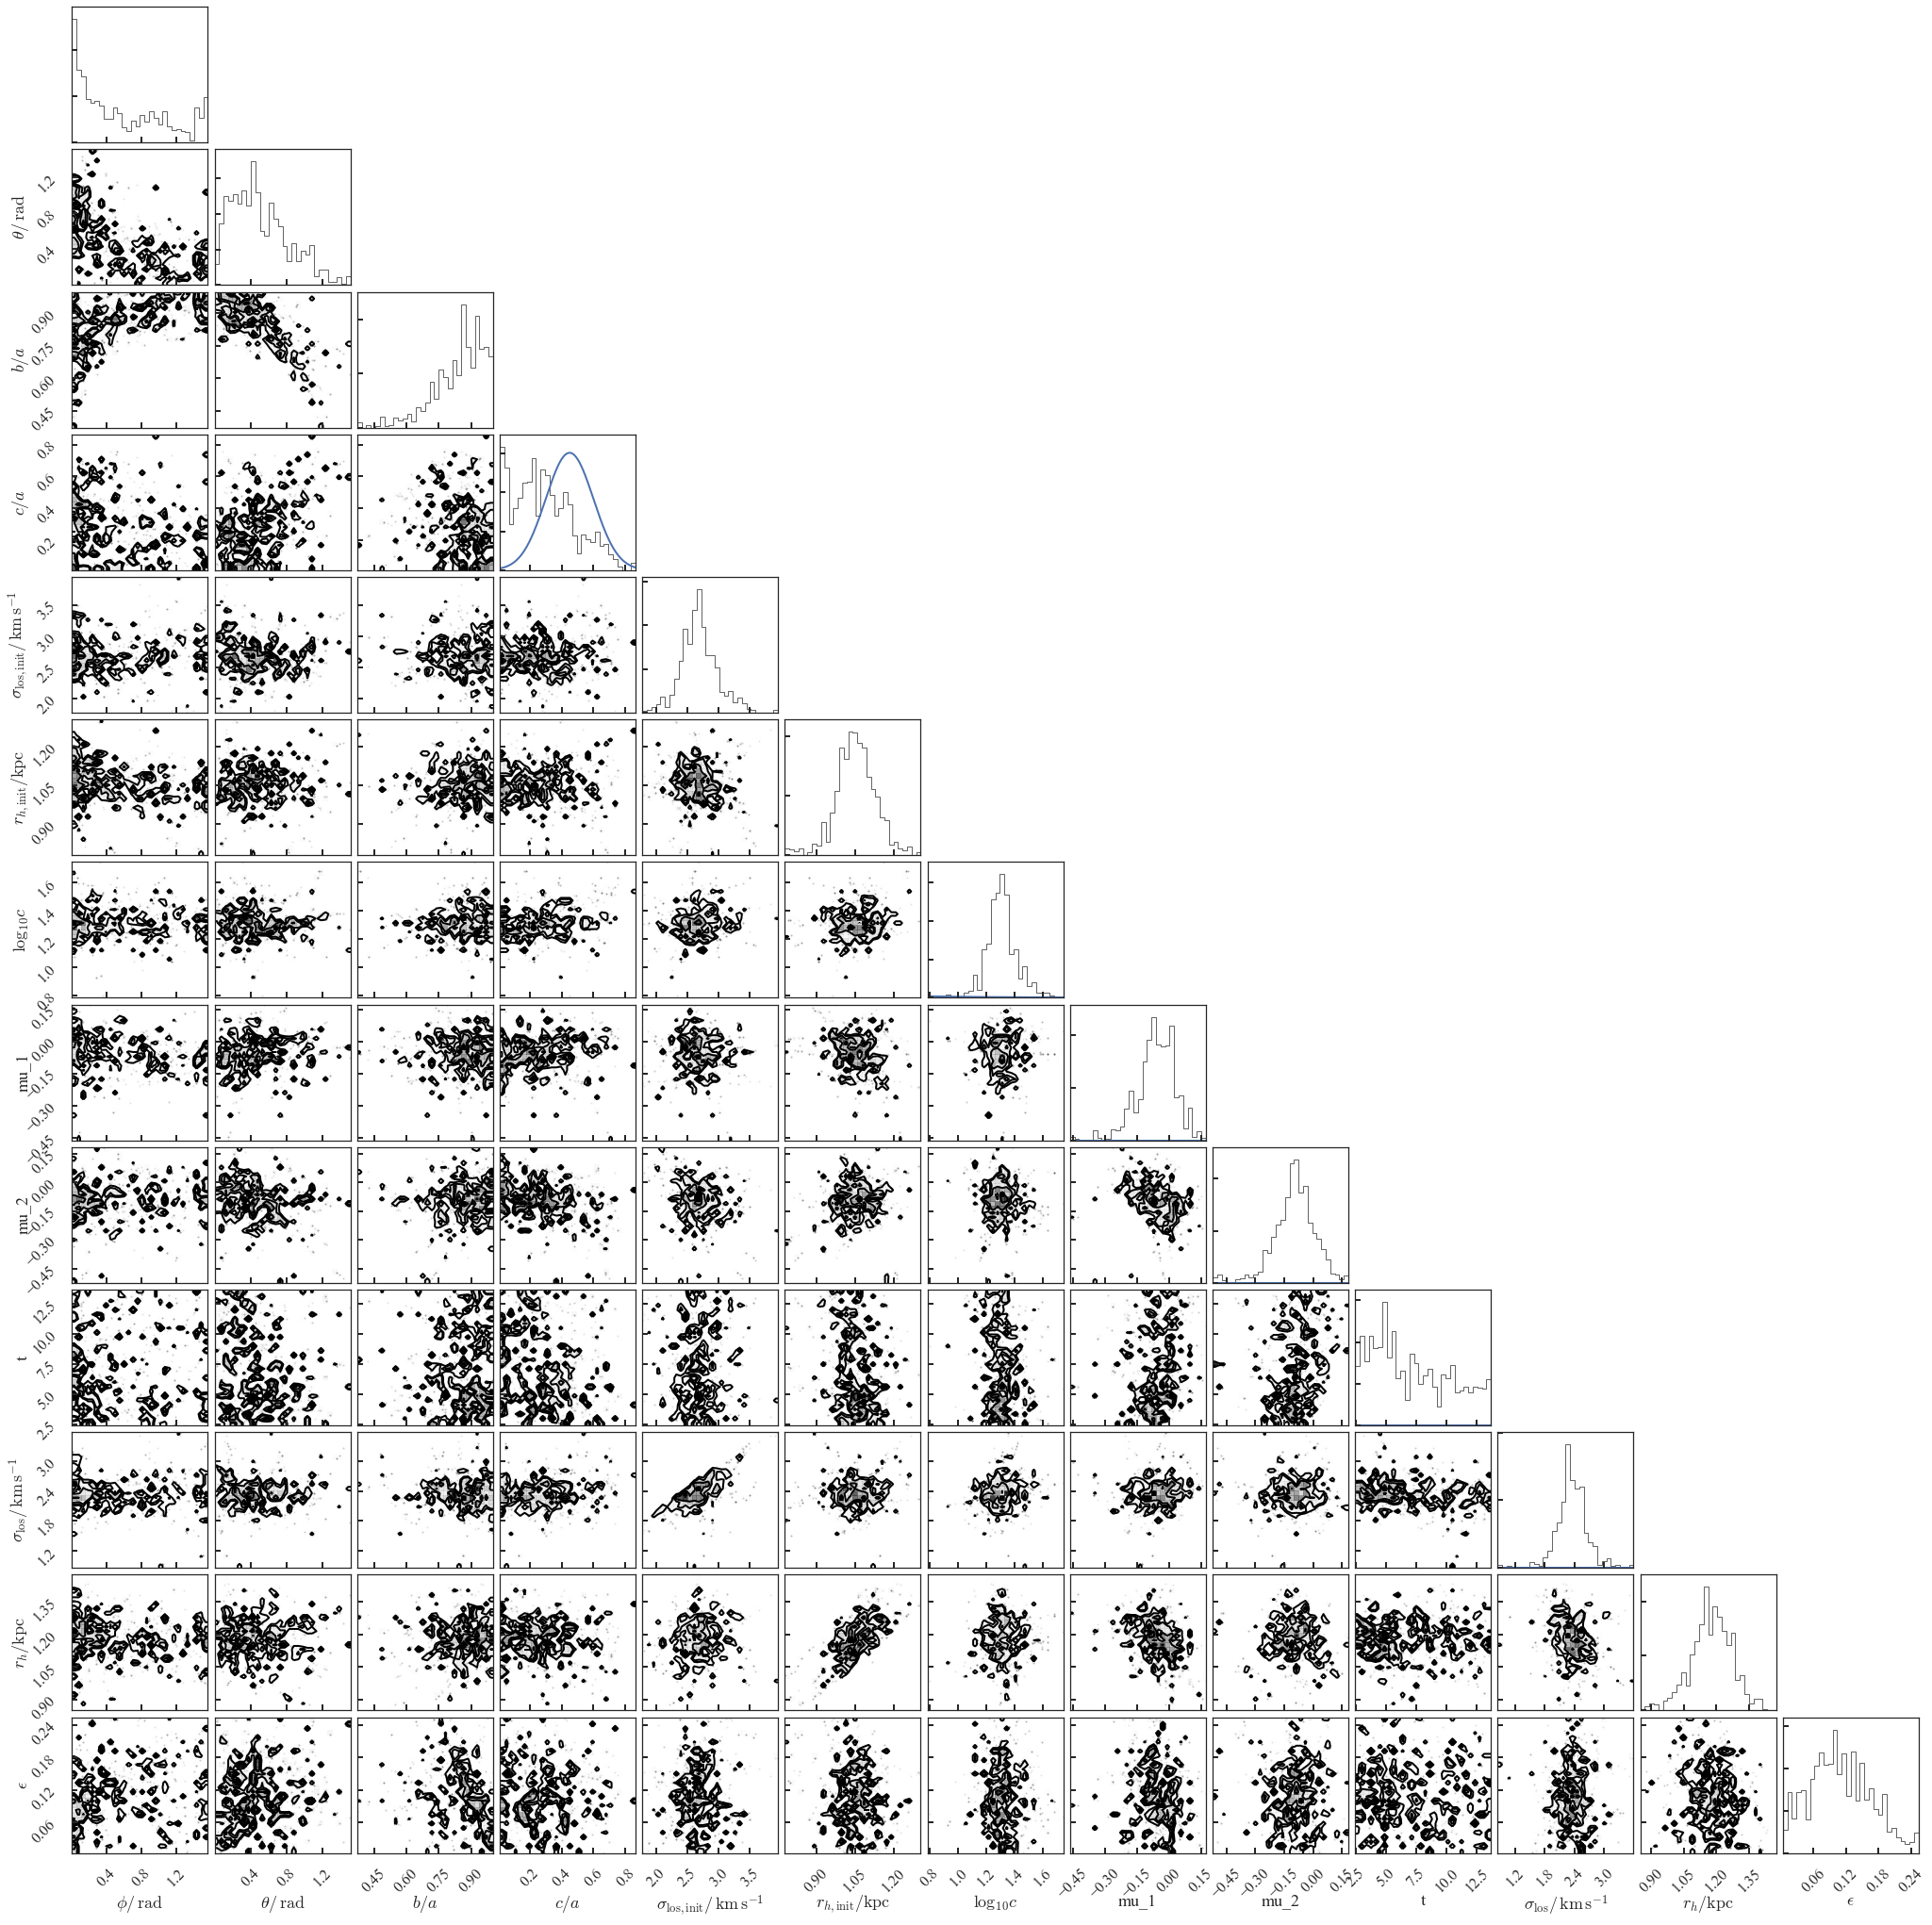

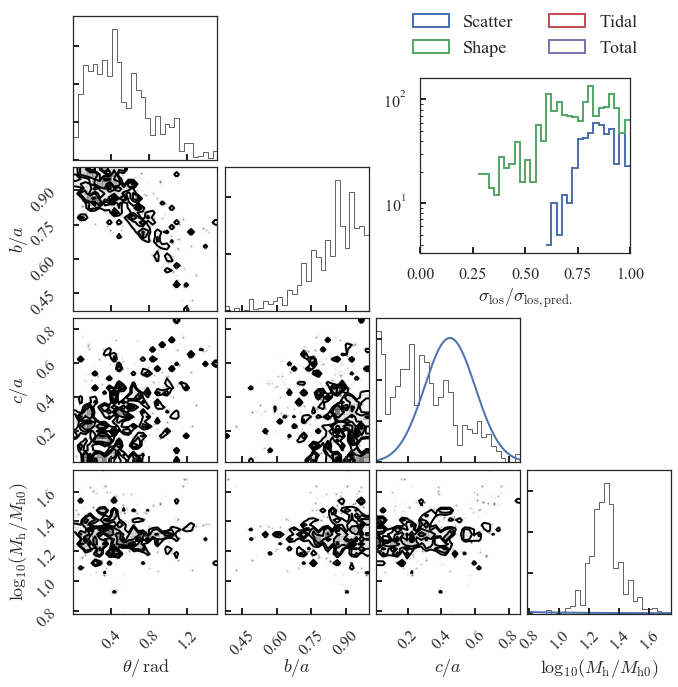

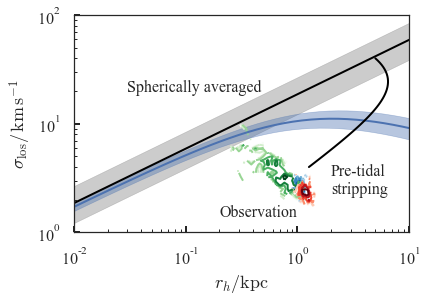

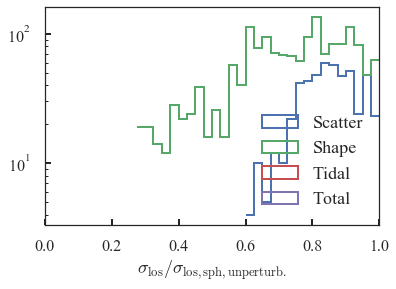

In [16]:
run('tmp',40)